## Taller en Clase: Pronóstico del Número de Ocupados

Objetivo del taller:
Empleando la información del número de ocupados (en miles de personas) para las 13 principales ciudades del país, construya un modelo de pronóstico para los próximos 6 meses utilizando los métodos de suavización exponencial vistos en clase, considerando versiones aditivas o multiplicativas según la naturaleza de la serie. Para ajustar los hiperparámetros del modelo (como alpha, beta y gamma), utilice optimización bayesiana a través de la librería Optuna, definiendo un espacio de búsqueda adecuado. La evaluación del modelo debe realizarse mediante un protocolo de validación temporal, utilizando una ventana móvil o recursiva, y empleando métricas apropiadas como RMSE.

Una vez ajustado el modelo, compárelo con el mejor modelo obtenido en el ejercicio anterior. Luego, elabore un informe breve (máximo una página de texto) explicando los resultados obtenidos y las proyecciones generadas, incluyendo las predicciones para los próximos 6 meses, mencione las principales limitaciones del pronóstico.

## Carga de paquetes

In [ ]:
pip install optuna

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import numpy as np
import optuna
import numpy as np
import pandas as pd
import warnings
import optuna
import seaborn as sns

import matplotlib.pyplot as plt
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.api import ExponentialSmoothing

# Configuración de warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Datos y EDA

In [ ]:
data = pd.read_excel("/content/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data = data.reset_index()
data.head()

,mes,TD_13ciudades,Ocupados,Desocupados,Inactivos
0,2001-01-01,20.946380,6923.604,1834.507,4600.718
1,2001-02-01,19.894213,7037.746,1747.820,4596.805
2,2001-03-01,19.221565,6945.973,1652.823,4807.120
3,2001-04-01,17.888575,6973.079,1519.137,4937.280
4,2001-05-01,17.945654,6994.462,1529.720,4928.911


In [ ]:
data.tail()

,mes,TD_13ciudades,Ocupados,Desocupados,Inactivos
217,2019-02-01,12.427409,10557.917,1498.272,6264.403
218,2019-03-01,11.975098,10760.776,1463.919,6116.140
219,2019-04-01,11.144286,10632.028,1333.469,6395.575
220,2019-05-01,11.500000,10813.000,1369.000,6199.000
221,2019-06-01,10.700000,10848.000,1306.000,6247.000


In [ ]:
data.shape

(222, 5)

In [ ]:
data.describe()

,mes,TD_13ciudades,Ocupados,Desocupados,Inactivos
count,222,222.000000,222.000000,222.000000,222.000000
mean,2010-03-17 06:22:42.162162176,12.601883,9160.852009,1290.681131,5500.277973
min,2001-01-01 00:00:00,8.140713,6923.604000,857.491000,4596.805000
25%,2005-08-08 18:00:00,10.396078,7971.103000,1152.874750,5308.814750
50%,2010-03-16 12:00:00,11.925036,9139.064500,1270.201000,5533.044500
75%,2014-10-24 06:00:00,14.087588,10458.510250,1398.899250,5752.608500
max,2019-06-01 00:00:00,20.946380,11037.199000,1834.507000,6395.575000
std,NaN,2.808235,1295.492800,181.948810,389.227213


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   mes            222 non-null    datetime64[ns]
 1   TD_13ciudades  222 non-null    float64       
 2   Ocupados       222 non-null    float64       
 3   Desocupados    222 non-null    float64       
 4   Inactivos      222 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 8.8 KB


<Axes: >

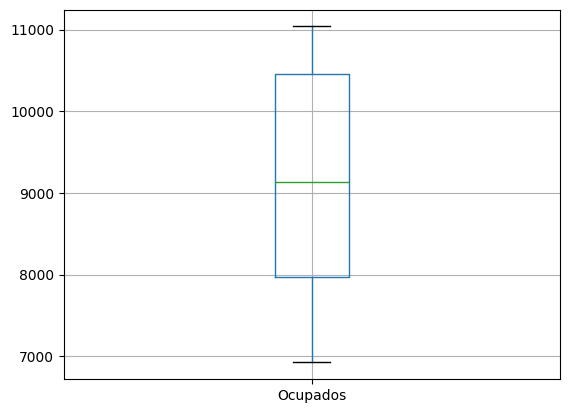

In [ ]:
data.boxplot(column = "Ocupados") # Diagrama de caja de una columna.

<Axes: >

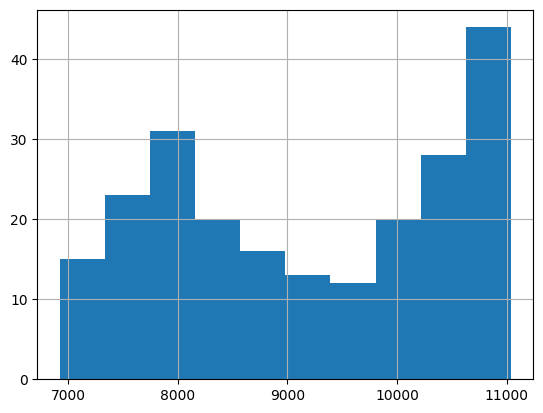

In [ ]:
data["Ocupados"].hist() # Histograma de una columna.

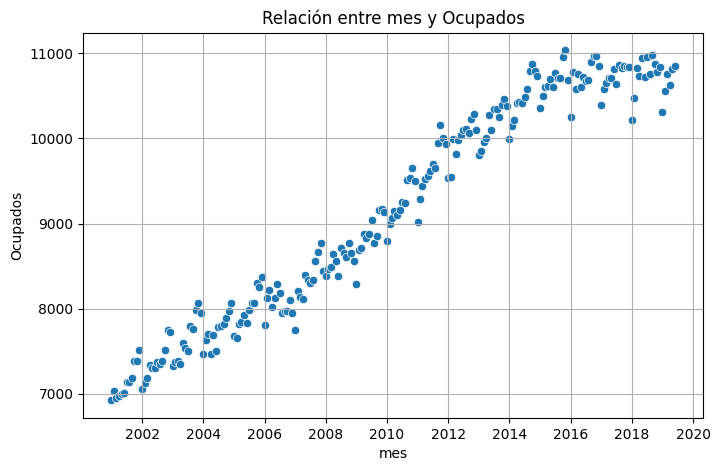

In [ ]:
# Gráfico de dispersión para visualizar la relación
plt.figure(figsize=(8,5))

sns.scatterplot(x='mes', y='Ocupados', data=data)
plt.title('Relación entre mes y Ocupados')
plt.xlabel('mes')
plt.ylabel('Ocupados')
plt.grid(True)
plt.show()

## Visualización Serie

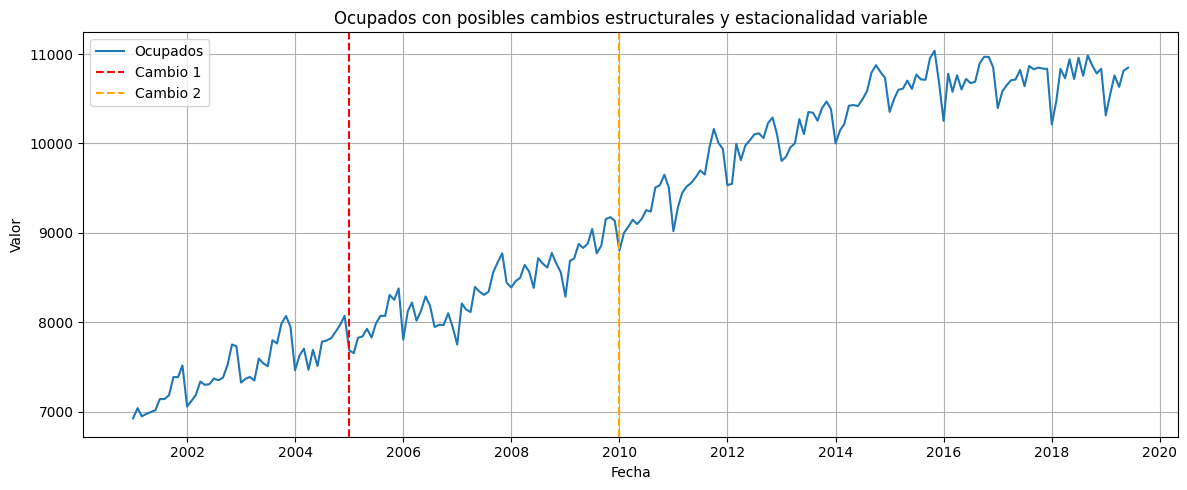

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(data['mes'], data['Ocupados'], label="Ocupados") # Corrected to plot 'Ocupados' against 'mes'

# To fix the axvline error, you need to provide specific x-coordinates (dates)
# for where the vertical lines should appear, not the entire 'Ocupados' Series.
# For demonstration, I'm using example dates. Please replace them with your intended dates.
plt.axvline(pd.to_datetime('2005-01-01'), color='red', linestyle='--', label="Cambio 1") # Example date
plt.axvline(pd.to_datetime('2010-01-01'), color='orange', linestyle='--', label="Cambio 2") # Example date

plt.title("Ocupados con posibles cambios estructurales y estacionalidad variable")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## VERIFICACIÓN Y PREPARACIÓN DE DATOS

In [ ]:
print(" VERIFICACIÓN DE DATOS")
print("=" * 50)

# Verificar que las fechas estén correctas
if not hasattr(data.index, 'strftime'):
    print(" El índice no es datetime. Corrigiendo...")
    # Si el índice no es datetime, asumimos que viene del Excel original
    data.index = pd.date_range(start='2001-01-01', periods=len(data), freq='MS')

serie = data['Ocupados']

print(f"Período real: {data.index.min()} a {data.index.max()}")
print(f"Tamaño: {len(serie)} observaciones")
print(f"Frecuencia: {pd.infer_freq(data.index)}")
print(f"Primeros 5 valores:\n{serie.head()}")
print(f"Últimos 5 valores:\n{serie.tail()}")

 VERIFICACIÓN DE DATOS
Período real: 2001-01-01 00:00:00 a 2019-06-01 00:00:00
Tamaño: 222 observaciones
Frecuencia: MS
Primeros 5 valores:
2001-01-01    6923.604
2001-02-01    7037.746
2001-03-01    6945.973
2001-04-01    6973.079
2001-05-01    6994.462
Freq: MS, Name: Ocupados, dtype: float64
Últimos 5 valores:
2019-02-01    10557.917
2019-03-01    10760.776
2019-04-01    10632.028
2019-05-01    10813.000
2019-06-01    10848.000
Freq: MS, Name: Ocupados, dtype: float64


## FUNCIÓN DE VALIDACIÓN

In [ ]:
def evaluar_expanding_forecast(serie, alpha, beta, gamma, trend_type,
                              seasonal_type, seasonal_periods=12, window=24,
                              step_size=1, horizon=6, metric='rmse'):
    """
    Función con manejo robusto de parámetros
    """

    serie = pd.Series(serie).astype(float).dropna()
    n = len(serie)
    predichos = []
    observados = []

    # Puntos de validación
    puntos_finales = list(range(n - window, n - horizon, step_size))

    for end_train in puntos_finales:
        if end_train < seasonal_periods * 2:  # Mínimo para estacionalidad
            continue

        #train = serie.iloc[:end_train] # Ventana recursiva
        #test = serie.iloc[end_train:end_train + horizon]

        # VENTANA MÓVIL: tamaño FIJO (window_size)
        start_train = end_train - window  # ← Calcular inicio de ventana
        train = serie.iloc[start_train:end_train]  # ← Ventana de tamaño fijo
        test = serie.iloc[end_train:end_train + horizon]

        if len(test) < horizon:
            continue

        try:
            # Configuración robusta del modelo
            model = ExponentialSmoothing(
                train,
                trend=trend_type,
                seasonal=seasonal_type,
                seasonal_periods=seasonal_periods
            )

            # Parámetros de ajuste
            fit_params = {
                'smoothing_level': alpha,
                'optimized': False,
                'remove_bias': False
            }

            # Solo agregar parámetros si el componente existe
            if trend_type and trend_type != "none":
                fit_params['smoothing_trend'] = beta
            if seasonal_type and seasonal_type != "none":
                fit_params['smoothing_seasonal'] = gamma

            fitted_model = model.fit(**fit_params)
            pred = fitted_model.forecast(steps=horizon)

            # Validar que las predicciones sean razonables
            if pred.isna().any() or (pred < 0).any():
                continue

        except Exception as e:
            continue

        # Solo considerar predicciones válidas
        valid_mask = (~pred.isna()) & (~test.isna())
        if valid_mask.sum() > 0:
            predichos.extend(pred[valid_mask].tolist())
            observados.extend(test[valid_mask].tolist())

    if len(predichos) < horizon:  # Mínimo de puntos para evaluación
        return np.inf

    # Cálculo de métrica
    predichos = np.array(predichos)
    observados = np.array(observados)

    if metric == 'rmse':
        return np.sqrt(mean_squared_error(observados, predichos))
    elif metric == 'mae':
        return np.mean(np.abs(observados - predichos))
    else:
        raise ValueError("Metric must be 'rmse' or 'mae'")

## OPTIMIZACIÓN

In [ ]:
print("\n OPTIMIZACIÓN BAYESIANA")
print("=" * 50)

def objective(trial):
    """
    Función objetivo mejorada - forzando componentes de tendencia
    """
    # ESPACIO DE BÚSQUEDA
    trend_type = trial.suggest_categorical("trend_type", ["add", None])  # Solo aditiva o ninguna
    seasonal_type = trial.suggest_categorical("seasonal_type", ["add", "mul"])
    seasonal_periods = trial.suggest_int("seasonal_periods", 10, 12)  # Focalizado en anual

    # PARÁMETROS
    alpha = trial.suggest_float("alpha", 0.1, 0.9)

    # BETA
    beta = trial.suggest_float("beta", 0.01, 0.3)  # Valores más bajos para tendencia

    gamma = trial.suggest_float("gamma", 0.1, 0.5)  # Estacionalidad moderada

    return evaluar_expanding_forecast(
        serie=serie,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        trend_type=trend_type,
        seasonal_type=seasonal_type,
        seasonal_periods=seasonal_periods,
        window=24,  # Ventana más grande para más estabilidad
        step_size=3,  # Menos puntos de validación pero más estables
        horizon=6,
        metric='rmse'
    )

# Ejecutar optimización
print("Iniciando optimización bayesiana mejorada...")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40, show_progress_bar=True)

# Resultados de la optimización
print("\n OPTIMIZACIÓN COMPLETADA")
print("=" * 40)
best_params = study.best_params
print(f"Mejores parámetros encontrados:")
print(f"  • Trend type: {best_params['trend_type']}")
print(f"  • Seasonal type: {best_params['seasonal_type']}")
print(f"  • Seasonal periods: {best_params['seasonal_periods']}")
print(f"  • Alpha: {best_params['alpha']:.4f}")
print(f"  • Beta: {best_params['beta']:.4f}")  # ¡Ahora siempre definido!
print(f"  • Gamma: {best_params['gamma']:.4f}")
print(f"Mejor RMSE: {study.best_value:.4f}")

[I 2025-11-22 14:29:09,476] A new study created in memory with name: no-name-43544b60-d449-43e6-bd90-3a4d540a8777



 OPTIMIZACIÓN BAYESIANA
Iniciando optimización bayesiana mejorada...


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-11-22 14:29:09,556] Trial 0 finished with value: 321.4503565076424 and parameters: {'trend_type': 'add', 'seasonal_type': 'mul', 'seasonal_periods': 10, 'alpha': 0.318182183920531, 'beta': 0.2570967587326313, 'gamma': 0.16838581785037454}. Best is trial 0 with value: 321.4503565076424.
[I 2025-11-22 14:29:09,592] Trial 1 finished with value: 235.84352470706853 and parameters: {'trend_type': None, 'seasonal_type': 'add', 'seasonal_periods': 11, 'alpha': 0.6898804369999573, 'beta': 0.012158424500207685, 'gamma': 0.12347844497846344}. Best is trial 1 with value: 235.84352470706853.
[I 2025-11-22 14:29:09,646] Trial 2 finished with value: 228.00528025072285 and parameters: {'trend_type': None, 'seasonal_type': 'mul', 'seasonal_periods': 11, 'alpha': 0.6351887490697428, 'beta': 0.057683908190270514, 'gamma': 0.1656793558151552}. Best is trial 2 with value: 228.00528025072285.
[I 2025-11-22 14:29:09,688] Trial 3 finished with value: 281.5181017764395 and parameters: {'trend_type': No

## MODELO FINAL

In [51]:
print("\n ENTRENANDO MODELO FINAL")
print("=" * 50)

# Configuración del modelo final
model_final = ExponentialSmoothing(
    serie,
    trend=best_params["trend_type"],
    seasonal=best_params["seasonal_type"],
    seasonal_periods=best_params["seasonal_periods"]
)

# Parámetros de ajuste
fit_params = {
    'smoothing_level': best_params["alpha"],
    'optimized': False,
    'remove_bias': False
}

# Usar beta solo si hay tendencia
if best_params["trend_type"] and best_params["trend_type"] != "none":
    fit_params['smoothing_trend'] = best_params["beta"]

# Usar gamma solo si hay estacionalidad
if best_params["seasonal_type"] and best_params["seasonal_type"] != "none":
    fit_params['smoothing_seasonal'] = best_params["gamma"]

# Ajustar modelo
ets_result = model_final.fit(**fit_params)

# Pronóstico para los próximos 6 meses
forecast_steps = 6
point_forecast = ets_result.forecast(forecast_steps)

# Intervalos de confianza más realistas
residuals_std = ets_result.resid.std()
conf_lower = point_forecast - 1.96 * residuals_std
conf_upper = point_forecast + 1.96 * residuals_std

# Crear DataFrame de resultados
forecast_dates = pd.date_range(
    start=serie.index[-1] + pd.DateOffset(months=1),
    periods=forecast_steps,
    freq='MS'
)

preds_hw_final = pd.DataFrame({
    'Point_forecast': point_forecast.values,
    'lower_95': conf_lower.values,
    'upper_95': conf_upper.values
}, index=forecast_dates)

print("\n📊 PRONÓSTICO PARA LOS PRÓXIMOS 6 MESES:")
print("=" * 45)
for i, (fecha, fila) in enumerate(preds_hw_final.iterrows(), 1):
    print(f"Mes {i} ({fecha.strftime('%Y-%m')}): {fila['Point_forecast']:.0f} "
          f"(IC 95%: {fila['lower_95']:.0f} - {fila['upper_95']:.0f})")


 ENTRENANDO MODELO FINAL

📊 PRONÓSTICO PARA LOS PRÓXIMOS 6 MESES:
Mes 1 (2019-07): 10819 (IC 95%: 10575 - 11062)
Mes 2 (2019-08): 10791 (IC 95%: 10547 - 11034)
Mes 3 (2019-09): 10866 (IC 95%: 10623 - 11110)
Mes 4 (2019-10): 10928 (IC 95%: 10684 - 11171)
Mes 5 (2019-11): 10929 (IC 95%: 10685 - 11172)
Mes 6 (2019-12): 10856 (IC 95%: 10612 - 11099)


## VISUALIZACIÓN


 GENERANDO VISUALIZACIÓN CORREGIDA


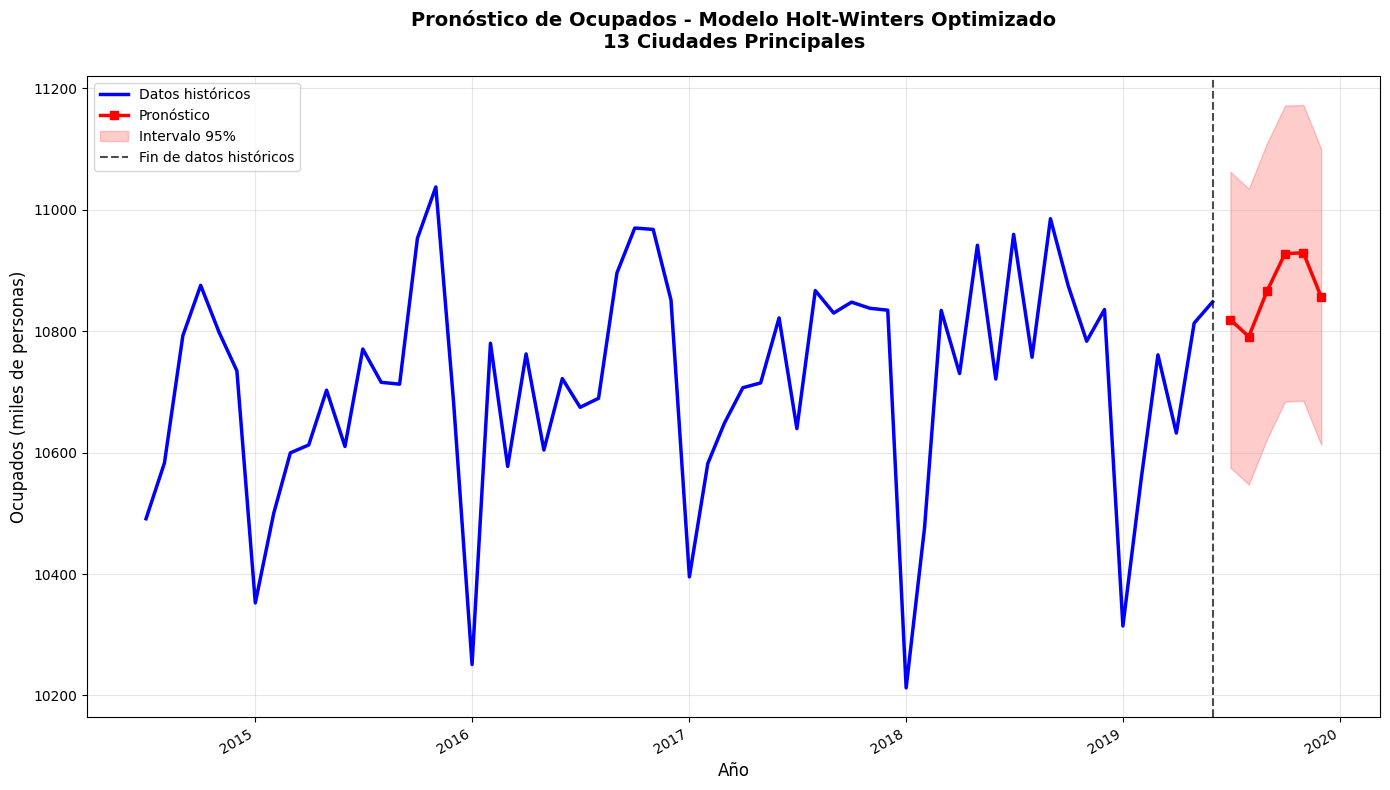

In [ ]:
print("\n GENERANDO VISUALIZACIÓN CORREGIDA")
print("=" * 50)

plt.figure(figsize=(14, 8))

# Datos históricos (últimos 5 años para mejor visualización)
historical_cutoff = 60  # 5 años
historical_data = serie.iloc[-historical_cutoff:] if len(serie) > historical_cutoff else serie

# Plot histórico
plt.plot(historical_data.index, historical_data.values,
         label='Datos históricos', color='blue', linewidth=2.5)

# Plot pronóstico
plt.plot(preds_hw_final.index, preds_hw_final['Point_forecast'],
         label='Pronóstico', color='red', linewidth=2.5, marker='s', markersize=6)

# Área de confianza
plt.fill_between(preds_hw_final.index,
                preds_hw_final['lower_95'],
                preds_hw_final['upper_95'],
                alpha=0.2, color='red', label='Intervalo 95%')

# Línea vertical separando histórico y pronóstico
last_historical_date = historical_data.index[-1]
plt.axvline(x=last_historical_date, color='black', linestyle='--', alpha=0.7, label='Fin de datos históricos')

plt.title('Pronóstico de Ocupados - Modelo Holt-Winters Optimizado\n13 Ciudades Principales',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Ocupados (miles de personas)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Formatear eje x para mostrar años correctamente
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

## EVALUACIÓN COMPLETA

In [ ]:
print("\n EVALUACIÓN COMPLETA DEL MODELO")
print("=" * 50)

# Métricas de ajuste
fitted_values = ets_result.fittedvalues
train_rmse = np.sqrt(mean_squared_error(serie[best_params["seasonal_periods"]:],
                                      fitted_values[best_params["seasonal_periods"]:]))

# Análisis de residuales
residuals = ets_result.resid
residual_mean = residuals.mean()
residual_std = residuals.std()

print(f"• RMSE Validación (Optuna): {study.best_value:.4f}")
print(f"• RMSE Entrenamiento: {train_rmse:.4f}")
print(f"• Media de Residuales: {residual_mean:.4f}")
print(f"• Desviación Estándar Residuales: {residual_std:.4f}")
print(f"• Parámetros del modelo:")
print(f"    - Alpha (nivel): {best_params['alpha']:.4f}")
print(f"    - Beta (tendencia): {best_params.get('beta', 'No aplica')}")
print(f"    - Gamma (estacionalidad): {best_params['gamma']:.4f}")


 EVALUACIÓN COMPLETA DEL MODELO
• RMSE Validación (Optuna): 144.5757
• RMSE Entrenamiento: 132.6488
• Media de Residuales: 39.0381
• Desviación Estándar Residuales: 124.2524
• Parámetros del modelo:
    - Alpha (nivel): 0.4117
    - Beta (tendencia): 0.011369169506818294
    - Gamma (estacionalidad): 0.1482


## ANÁLISIS DE TENDENCIA Y ESTACIONALIDAD

In [ ]:
print("\n🔍 ANÁLISIS DE COMPONENTES")
print("=" * 50)

if best_params['trend_type']:
    print(f" El modelo identificó tendencia {best_params['trend_type']}")
    print(f"   - Beta = {best_params['beta']:.4f} (suavización de tendencia)")
else:
    print(" El modelo no identificó tendencia significativa")
    print("   - Esto puede indicar estacionariedad en la serie")

print(f" Estacionalidad {best_params['seasonal_type']} con período {best_params['seasonal_periods']}")
print(f"   - Gamma = {best_params['gamma']:.4f} (suavización estacional)")


🔍 ANÁLISIS DE COMPONENTES
 El modelo no identificó tendencia significativa
   - Esto puede indicar estacionariedad en la serie
 Estacionalidad add con período 12
   - Gamma = 0.1482 (suavización estacional)
